## Working on the adjacency matrices first

#### Discriminating by year first

In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

df = pd.read_csv("../data/CosciaRios2012_DataBase.csv")
os.makedirs('../data/cartel_adj_mat', exist_ok=True)

family_cols = df.columns[3:]
matrices = {}

for year in range(df['Year'].min(), df['Year'].max() + 1):
    df_year = df[df['Year'] == year].set_index('Code')[family_cols].astype(int)
    adj_weighted = df_year.T @ df_year
    np.fill_diagonal(adj_weighted.values, 0)
    matrices[year] = adj_weighted
    
    with open(f'../data/cartel_adj_mat/{year}.csv', 'w') as f:
        adj_weighted.to_csv(f)

matrices

{1990:                       Beltran_Leyva  Beltran_Leyva_Family  Familia  Golfo  \
 Beltran_Leyva                     0                     0        0      0   
 Beltran_Leyva_Family              0                     0        0      0   
 Familia                           0                     0        0      0   
 Golfo                             0                     0        0      0   
 Juarez                            0                     0        0      0   
 Sinaloa                           0                     0        0      0   
 Sinaloa_Family                    0                     0        0      0   
 Tijuana                           0                     0        0      0   
 Zetas                             0                     0        0      0   
 Otros                             0                     0        0      0   
 
                       Juarez  Sinaloa  Sinaloa_Family  Tijuana  Zetas  Otros  
 Beltran_Leyva              0        0               0

#### Non-zero adjacency matrices

In [2]:
nonzero_years = [year for year, mat in matrices.items() if np.any(mat != 0)]
print("Years with non-zero adjacency entries:", nonzero_years)

Years with non-zero adjacency entries: [1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]


This means that years 1990 and 1991 do not have the ability to create edges between families as there is no family presence in any municipality, or there is no **shared** presence that creates an edge 

#### Maximum weight (number of municipalities shared by two families) in all years

In [3]:
max_weight = np.array(list(matrices.values())).max() # will use this value to plot thick edges later
max_weight

189

#### Across all years combined

In [4]:
# number of appearances per family in each municipality across all 20 years
df_collapsed = df.groupby('Code')[family_cols].sum() #muni codes are already indeces 
df_collapsed = (df_collapsed > 0).astype(int)

# project on families
adj_all_years = df_collapsed.T @ df_collapsed
np.fill_diagonal(adj_all_years.values, 0)

adj_all_years # weights: number of distinct municipalities where each pair of families have co-appeared, not necessarily in the same year

,Beltran_Leyva,Beltran_Leyva_Family,Familia,Golfo,Juarez,Sinaloa,Sinaloa_Family,Tijuana,Zetas,Otros
Beltran_Leyva,0,71,132,190,83,168,67,77,219,56
Beltran_Leyva_Family,71,0,45,60,44,64,38,39,60,38
Familia,132,45,0,188,66,131,49,59,221,55
Golfo,190,60,188,0,108,203,58,93,381,68
Juarez,83,44,66,108,0,130,45,74,103,53
Sinaloa,168,64,131,203,130,0,66,99,218,67
Sinaloa_Family,67,38,49,58,45,66,0,37,59,38
Tijuana,77,39,59,93,74,99,37,0,84,47
Zetas,219,60,221,381,103,218,59,84,0,64
Otros,56,38,55,68,53,67,38,47,64,0


In [5]:
adj_all_years.equals(adj_all_years.T)  # Check for symmetry

True

---

## Projection on family cartels
Discriminating by year

In [6]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv("../data/CosciaRios2012_DataBase.csv")

family_cols = df.columns[3:]
graphs_by_year = {} #key: year, value: networkx graph
edge_data = {}

for year in range(df['Year'].min(), df['Year'].max() + 1):
    df_year = df[df['Year'] == year].set_index('Code')[family_cols].astype(int)
    adj_weighted = df_year.T @ df_year
    np.fill_diagonal(adj_weighted.values, 0)

    A = adj_weighted.values  #numpy
    labels = adj_weighted.index.to_numpy()  # family labels
    
    # indices of upper triangle, excluding diagonal
    rows, cols = np.triu_indices(A.shape[0], k=1) #pairs of indices

    # weights at those positions
    weights = A[rows, cols]

    # keep only existing edges
    mask = weights > 0

    edge_list = np.column_stack((
        labels[rows[mask]],
        labels[cols[mask]],
        weights[mask]
    ))

    G_year = nx.Graph()
    G_year.add_nodes_from(family_cols)
    G_year.add_weighted_edges_from(edge_list)
    graphs_by_year[year] = G_year

# example 1
graphs_by_year[2005].nodes()


NodeView(('Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros'))

#### Plotting an example from the graphs_by_year dict

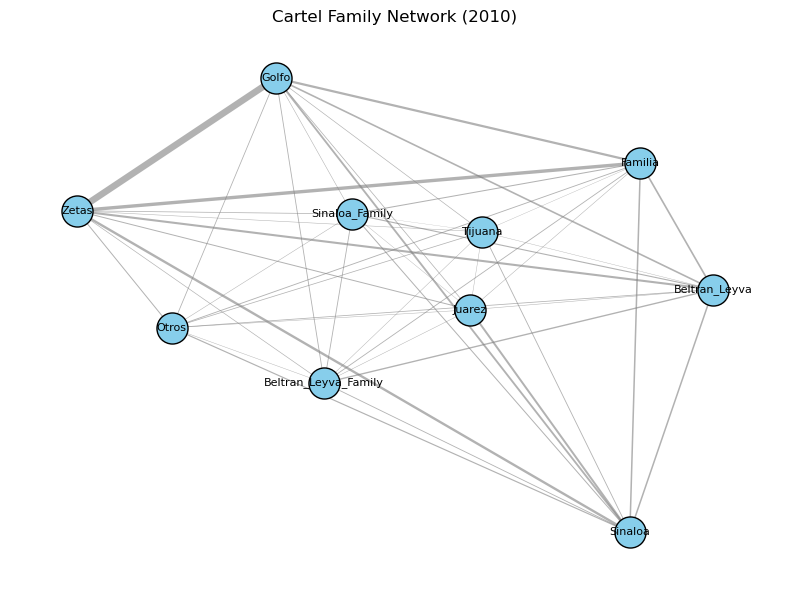

In [7]:
# example 2
G_example = graphs_by_year[2010]
plt.figure(figsize=(8,6))
pos = nx.kamada_kawai_layout(G_example, weight='weight') #nodes with higher weights are closer together

example_edges = G_example.edges()
example_weights = np.array([G_example[u][v]['weight'] for u,v in example_edges])
example_weights = example_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_example, pos, width=example_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_example, pos, node_color="skyblue", node_size=500, edgecolors="black")
nx.draw_networkx_labels(G_example, pos, font_size=8, font_color="black")

plt.title("Cartel Family Network (2010)")
plt.axis('off')
plt.tight_layout()
plt.show()

Aggregate graph over all 20 years (weight represents number of distinct municipalities two families have had in common)

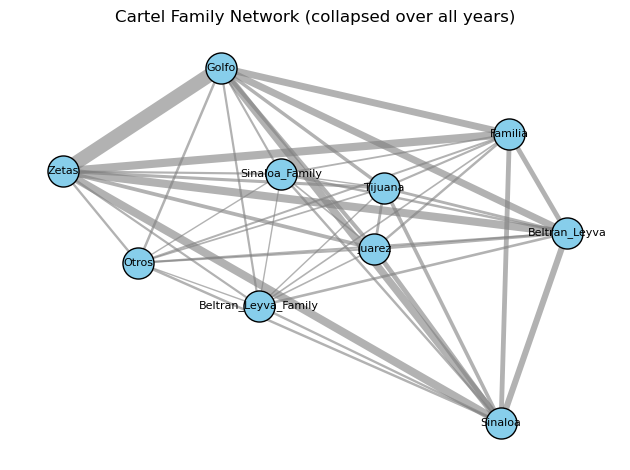

In [8]:
G_collapsed = nx.Graph()
G_collapsed.add_nodes_from(family_cols)
G_collapsed = nx.from_pandas_adjacency(adj_all_years)

collapsed_edges = G_collapsed.edges()
collapsed_weights = np.array([G_collapsed[u][v]['weight'] for u,v in collapsed_edges])
collapsed_weights = collapsed_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_collapsed, pos, width=collapsed_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_collapsed, pos, node_color="skyblue", node_size=500, edgecolors="black")
nx.draw_networkx_labels(G_collapsed, pos, font_size=8, font_color="black")

plt.title("Cartel Family Network (collapsed over all years)")
plt.axis('off')
plt.tight_layout()
plt.show()

The difference in weights from 2010 is clear, suggesting each year adds connections between families through different municipalities:

- If families always appeared in the same municipalities year after year, then 2010 (latest year) would capture most of the cumulative pattern
- Since 2010 is much sparser than the collapsed network, it means families co-occur in different sets of municipalities across different years
- This reveals temporal variation in geographic operations rather than static territorial control


#### Observing network evolution for the last 9 years (static)

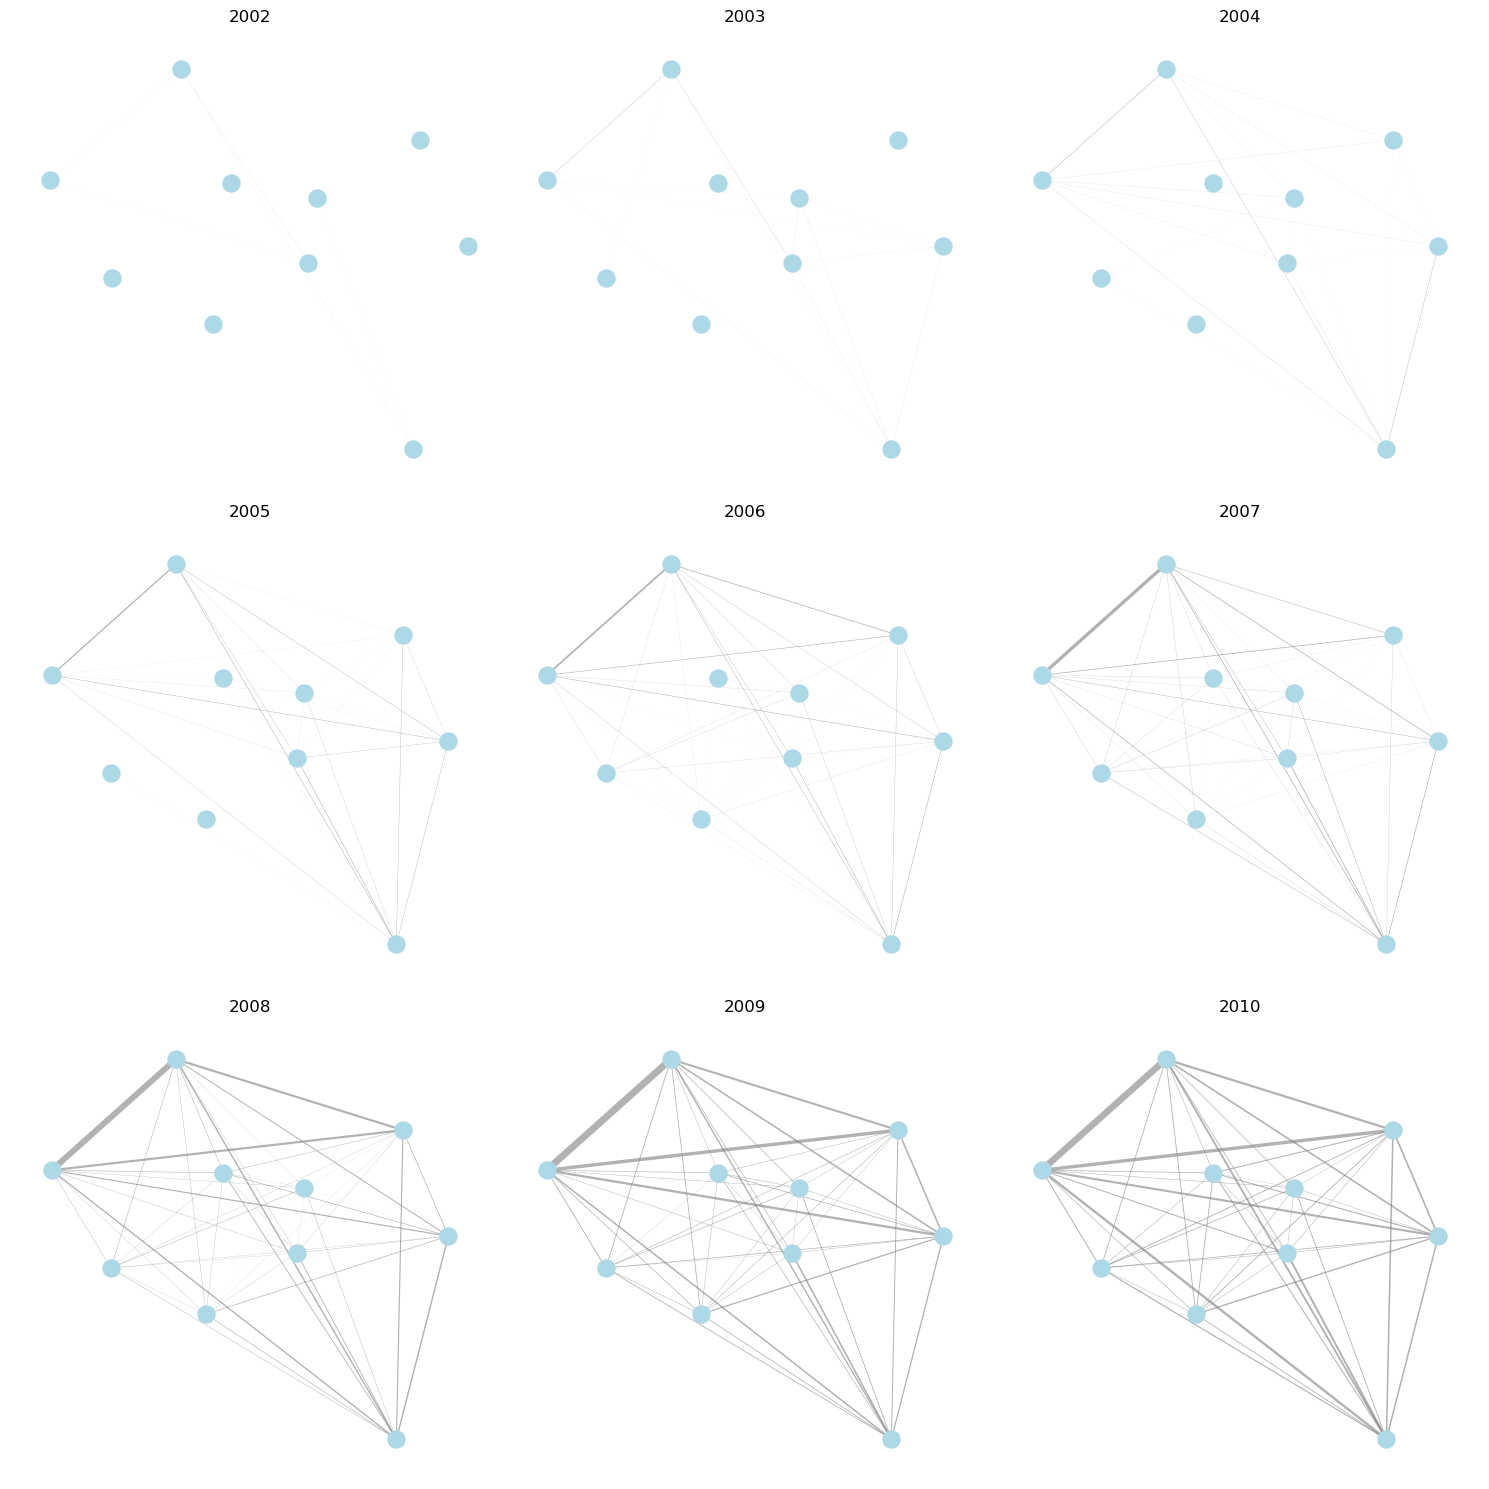

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Select years to visualize
years_to_plot = list(range(2002, 2011))  # 2004–2010 inclusive

# defining layout once (so positions are consistent across years)
reference_year = years_to_plot[-1]
pos = nx.kamada_kawai_layout(graphs_by_year[reference_year], weight='weight') #nodes with higher weights are closer together

# Create figure with one row and N columns
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    G = graphs_by_year[year]
    year_edges = G.edges()
    year_weights = np.array([G[u][v]['weight'] for u,v in year_edges])
    year_weights = year_weights / max_weight * 5  # normalize for plotting
    
    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_edges(G, pos, width=year_weights, edge_color="gray", alpha=0.6, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=150, ax=ax)

    ax.set_title(str(year))
    ax.axis("off")

plt.tight_layout()
plt.show()

We observe edges get thicker and thicker over the years, but as we observed in the previous plot, those connections are not caused by the same co-ocurrence in the same municipalities.

#### Observing network evolution over all 20 years (animated plot)

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import os

# Select years to visualize
years_to_plot = list(range(min(graphs_by_year.keys()), max(graphs_by_year.keys()) + 1)) 

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the most dense of them all 
pos = nx.kamada_kawai_layout(graphs_by_year[2010], weight='weight') #nodes with higher weights are closer together

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for idx, year in enumerate(years_to_plot):
    G = graphs_by_year[year]
    year_edges = G.edges()
    year_weights = np.array([G[u][v]['weight'] for u,v in year_edges])
    year_weights = year_weights / max_weight * 10  # normalize for plotting
    
    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_edges(G, pos, width=year_weights, edge_color="gray", alpha=0.6)
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    plt.title(f"Original Projected Network on Families - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{idx:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/network_evolution.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'network_evolution.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_27188\3535928748.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'network_evolution.gif'


---
## Network properties over time

#### Number of nodes
Safe check

In [11]:
import pandas as pd

# Check number of nodes for each year
nodes_by_year = []
for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    n_nodes = G.number_of_nodes()
    nodes_by_year.append({'Year': year, 'Nodes': n_nodes})

nodes_df = pd.DataFrame(nodes_by_year)

print("NUMBER OF NODES (FAMILIES) PER YEAR")
print(nodes_df.to_string(index=False))
print(f"All years have {nodes_df['Nodes'].unique()[0]} nodes: {nodes_df['Nodes'].nunique() == 1}")


NUMBER OF NODES (FAMILIES) PER YEAR
 Year  Nodes
 1990     10
 1991     10
 1992     10
 1993     10
 1994     10
 1995     10
 1996     10
 1997     10
 1998     10
 1999     10
 2000     10
 2001     10
 2002     10
 2003     10
 2004     10
 2005     10
 2006     10
 2007     10
 2008     10
 2009     10
 2010     10
All years have 10 nodes: True


#### Number of edges per year 

REPORTED CASES BY YEAR
 Year  Edges
 1990      0
 1991      0
 1992      1
 1993      2
 1994      2
 1995      2
 1996      5
 1997      2
 1998      4
 1999      2
 2000      4
 2001     13
 2002      5
 2003     13
 2004     19
 2005     25
 2006     37
 2007     41
 2008     45
 2009     45
 2010     45


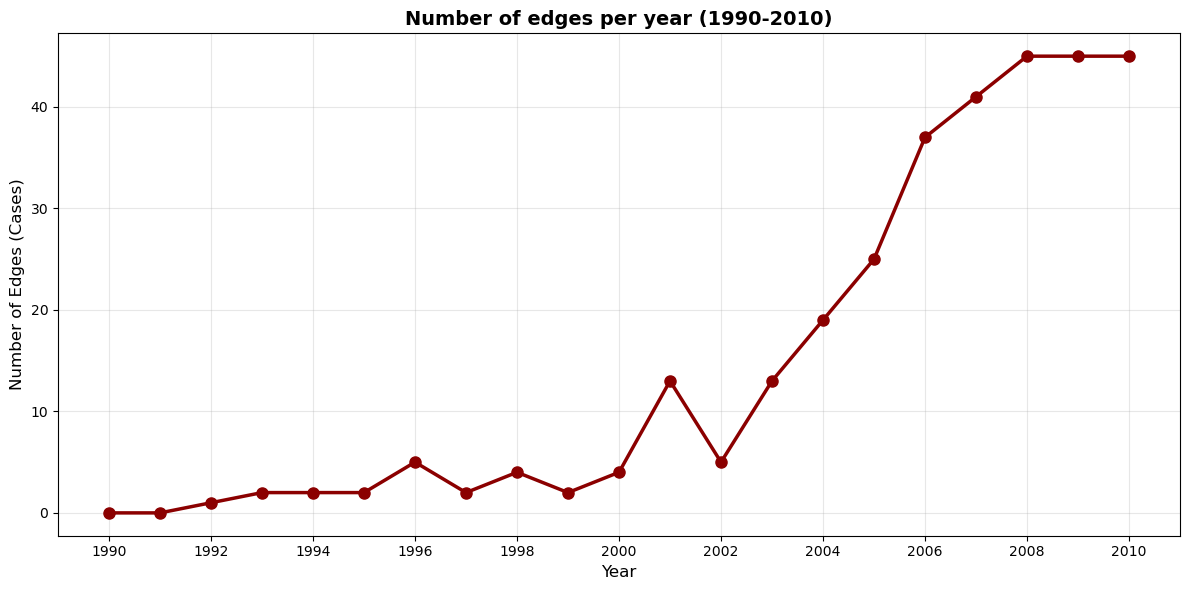

In [12]:
metrics_data = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    n_edges = G.number_of_edges()
    
    metrics_data.append({
        'Year': year,
        'Edges': n_edges
    })

metrics_df = pd.DataFrame(metrics_data)

# Print the number of edges per year
print("REPORTED CASES BY YEAR")
print(metrics_df.to_string(index=False))

# Plot: Number of Edges over time
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Year'], metrics_df['Edges'], marker='o', linewidth=2.5, markersize=8, color='darkred')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Edges (Cases)', fontsize=12)
plt.title('Number of edges per year (1990-2010)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/number_of_edges_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

#### Average degree

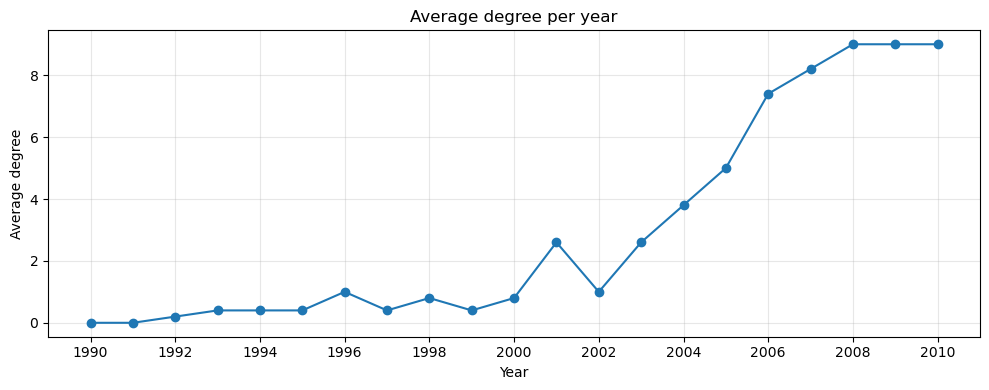

In [13]:
# Simple: compute and plot average (unweighted) degree per year
import pandas as pd
import matplotlib.pyplot as plt

avg_rows = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    n = G.number_of_nodes()
    if n > 0:
        avg_deg = sum(dict(G.degree()).values()) / n
    else:
        avg_deg = 0
    avg_rows.append({'Year': year, 'AverageDegree': round(avg_deg, 2)})

avg_df = pd.DataFrame(avg_rows)

plt.figure(figsize=(10,4))
plt.plot(avg_df['Year'], avg_df['AverageDegree'], marker='o', color='tab:blue')
plt.xlabel('Year')
plt.ylabel('Average degree')
plt.title('Average degree per year')
plt.grid(alpha=0.3)
plt.xticks(range(min(avg_df['Year']), max(avg_df['Year'])+1, 2))
plt.tight_layout()
plt.savefig('../presentation/average_degree_per_year.png', dpi=300, bbox_inches='tight')
plt.show()

Doesn’t change much from our number of edges since its just the number of edges divided per 10

#### Degree per family through the years

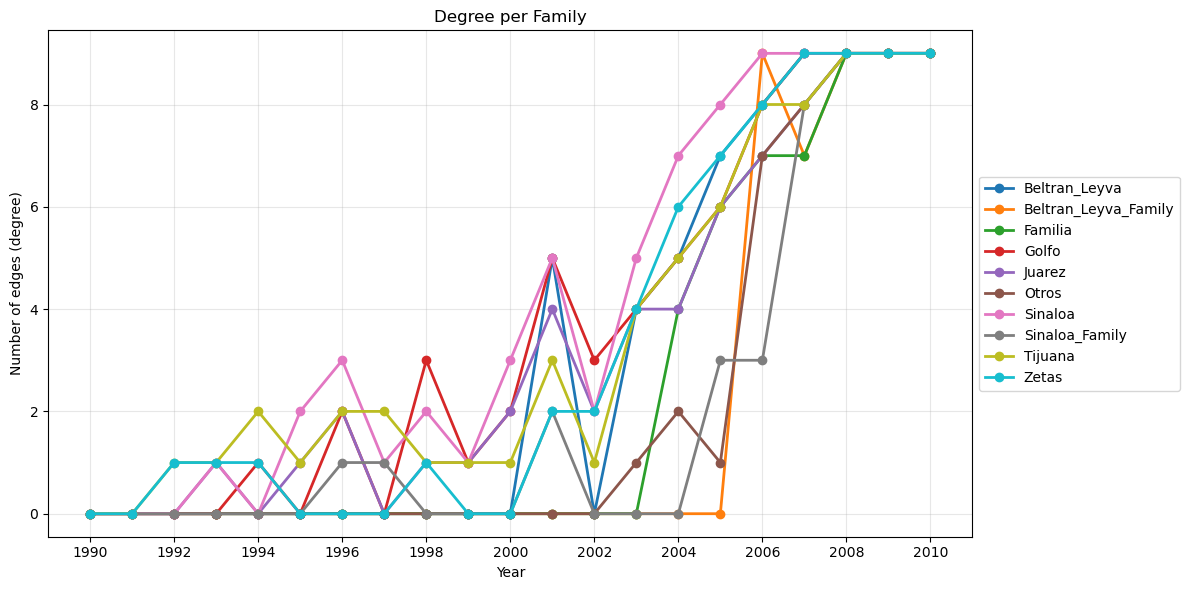

In [14]:
rows = []
for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]
    deg = dict(G.degree())
    # family nodes are strings; municipality nodes are numeric codes
    fam_nodes = sorted([n for n in G.nodes() if isinstance(n, str)])
    for fam in fam_nodes:
        rows.append({'Year': year, 'Family': fam, 'Degree': deg.get(fam, 0)})
df_deg = pd.DataFrame(rows)

pivot_deg = df_deg.pivot(index='Year', columns='Family', values='Degree').fillna(0)

# Plot: one line per family
plt.figure(figsize=(12, 6))
for fam in pivot_deg.columns:
    plt.plot(pivot_deg.index, pivot_deg[fam], marker='o', label=fam, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Number of edges (degree)')
plt.title('Degree per Family')
plt.grid(alpha=0.3)
plt.xticks(range(1990, 2011, 2))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

plt.savefig('../presentation/degree_per_family.png', dpi=300, bbox_inches='tight')

plt.show()

#### Density and Diameter

In [15]:
results = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]

    if nx.is_connected(G):
        diameter = nx.diameter(G)
    else:
        components = list(nx.connected_components(G))
        if not components:
            diameter = float('nan')
        
        largest_cc = G.subgraph(max(components, key=len))
        
        if largest_cc.number_of_nodes() > 1:
            diameter = nx.diameter(largest_cc)
        else:
            diameter = float('nan')
    
    results.append({
        'year': year,
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'diameter':  diameter
    })

results_df = pd.DataFrame(results)
results_df

,year,num_edges,density,diameter
0,1990,0,0.000000,NaN
1,1991,0,0.000000,NaN
2,1992,1,0.022222,1.0
3,1993,2,0.044444,1.0
4,1994,2,0.044444,2.0
5,1995,2,0.044444,2.0
6,1996,5,0.111111,3.0
7,1997,2,0.044444,2.0
8,1998,4,0.088889,3.0
9,1999,2,0.044444,1.0


The diameter being low in early years is a bit misleading since there are not many edges in the network so its not fully connected

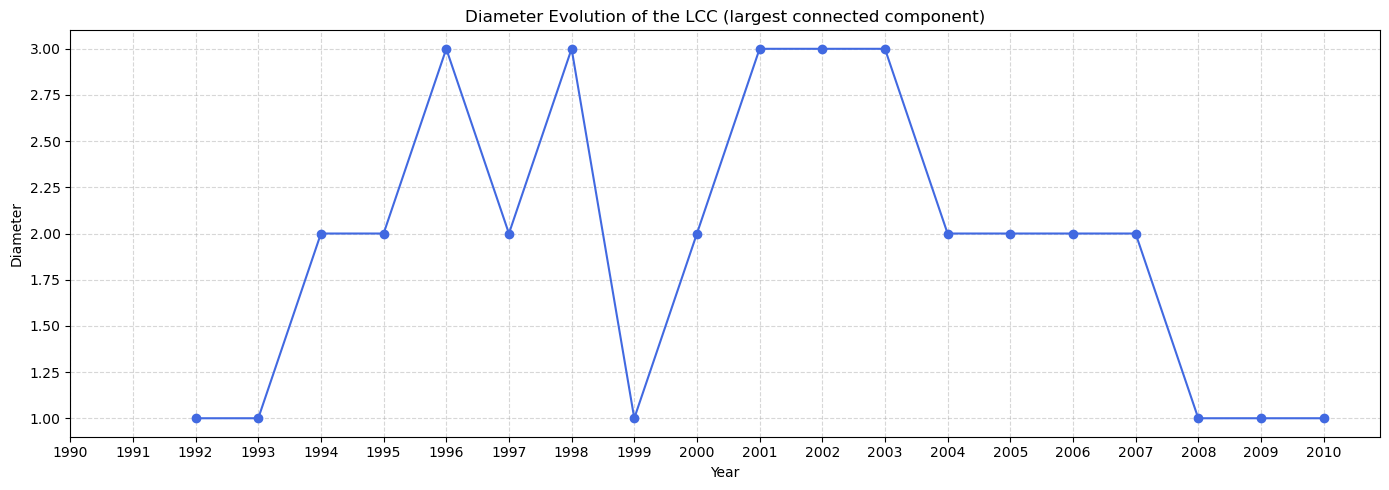

In [16]:
#plotting diameter evolution
plt.figure(figsize=(14,5))  
plt.plot(results_df['year'], results_df['diameter'], marker='o', linestyle='-', color='royalblue')
plt.xlabel('Year')
plt.ylabel('Diameter')
plt.title('Diameter Evolution of the LCC (largest connected component)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(results_df['year'], [str(int(y)) for y in results_df['year']])
plt.tight_layout()

plt.savefig('../presentation/diameter_evolution.png', dpi=300, bbox_inches='tight')

plt.show()

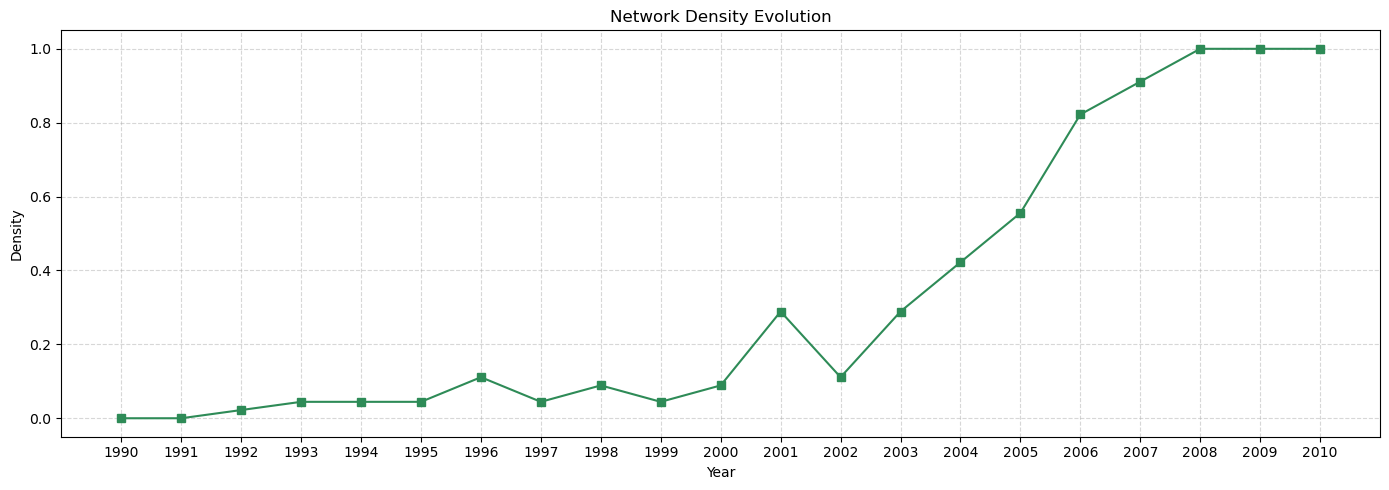

In [17]:
#plot the network density throughout the years

plt.figure(figsize=(14,5))
plt.plot(results_df['year'], results_df['density'], marker='s', linestyle='-', color='seagreen')
plt.xlabel('Year')
plt.ylabel('Density')
plt.title('Network Density Evolution')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(results_df['year'], [str(int(y)) for y in results_df['year']])
plt.tight_layout()
plt.savefig('../presentation/density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Computing sum of edge weights for each family per year 
This is interpreted as number of conflicts or clashes with other families that year (one municipality can cause up to 10 conflicts in the same year because all families are present in that municipality simultaneously)

In [18]:
# Stack all matrices into a 3D array (years × families × families)
years_sorted = sorted(matrices.keys())
matrices_3d = np.stack([matrices[year] for year in years_sorted], axis=0)  # Shape: (20, 10, 10)

# Sum across columns (axis=2) to get weight sum per family per year
# Result shape: (20, 10) - 20 years, 10 families
weight_sums = matrices_3d.sum(axis=2) #sum columns but keep the matrices and rows

# Create DataFrame
family_weights_df = pd.DataFrame(
    weight_sums,
    index=years_sorted,
    columns=family_cols
)

family_weights_df.index.name = 'year'
family_weights_df

,Beltran_Leyva,Beltran_Leyva_Family,Familia,Golfo,Juarez,Sinaloa,Sinaloa_Family,Tijuana,Zetas,Otros
year,,,,,,,,,,
1990,0,0,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0,0,0
1992,0,0,0,0,0,0,0,1,1,0
1993,0,0,0,0,1,1,0,1,1,0
1994,0,0,0,1,0,0,0,2,1,0
1995,0,0,0,0,1,3,0,2,0,0
1996,0,0,0,2,2,3,1,2,0,0
1997,0,0,0,0,0,2,1,3,0,0
1998,0,0,0,3,1,4,0,3,1,0


#### Getting average weight per year 
To observe how that contrasts with number of conflicts/violence level per year

In [19]:
#average sum of edge weights per family for each year
avg_weights_df =  family_weights_df.mean(axis=1).to_frame(name='average_weight_sum')
avg_weights_df

,average_weight_sum
year,
1990,0.0
1991,0.0
1992,0.2
1993,0.4
1994,0.4
1995,0.6
1996,1.0
1997,0.6
1998,1.2


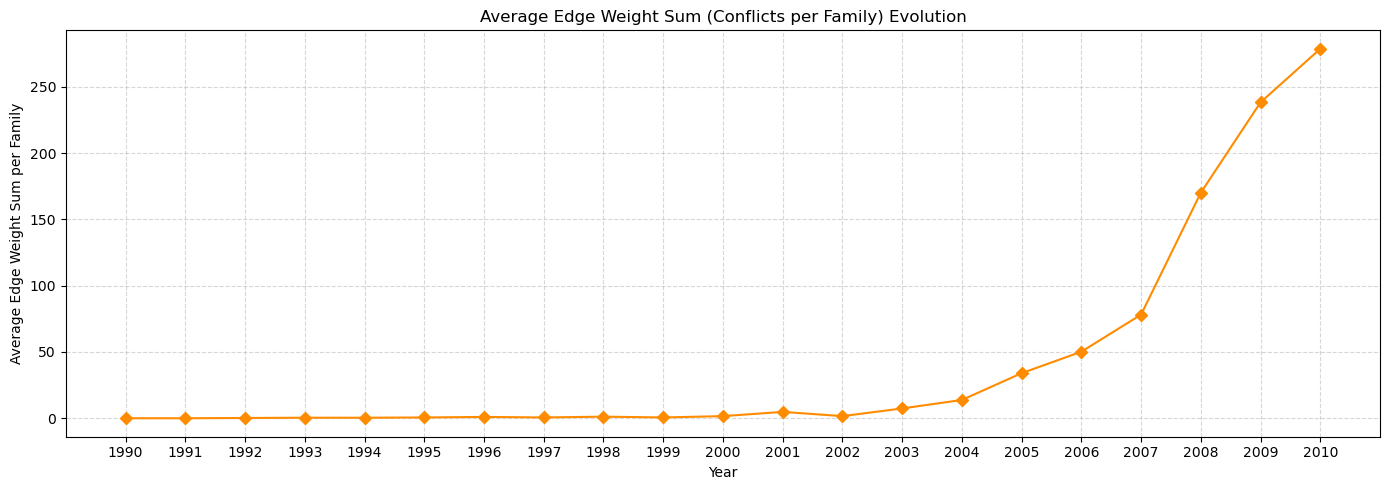

In [20]:
#plot the average sum of edge weights per family for each year
plt.figure(figsize=(14,5))
plt.plot(avg_weights_df.index, avg_weights_df['average_weight_sum'], marker='D', linestyle='-', color='darkorange')
plt.xlabel('Year')
plt.ylabel('Average Edge Weight Sum per Family')
plt.title('Average Edge Weight Sum (Conflicts per Family) Evolution')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(avg_weights_df.index, [str(int(y)) for y in avg_weights_df.index])
plt.tight_layout()
plt.savefig('../presentation/average_edge_weight_sum.png', dpi=300, bbox_inches='tight')
plt.show()

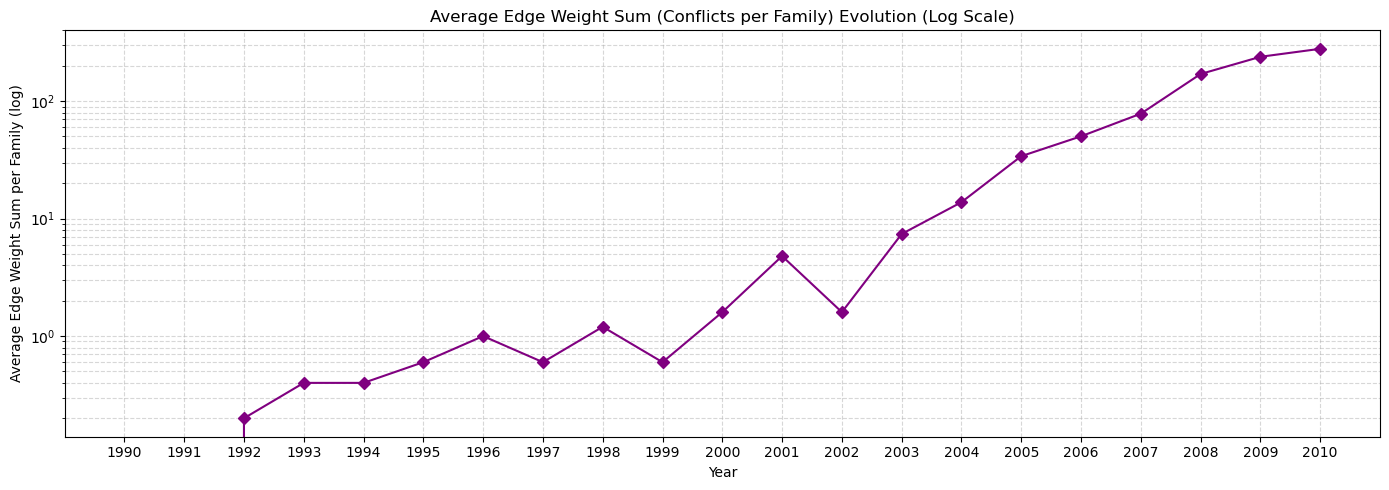

In [21]:
#plot the average sum of edge weights per family for each year (log scale)

plt.figure(figsize=(14,5))
plt.plot(avg_weights_df.index, avg_weights_df['average_weight_sum'], marker='D', linestyle='-', color='purple')
plt.xlabel('Year')
plt.ylabel('Average Edge Weight Sum per Family (log)')
plt.title('Average Edge Weight Sum (Conflicts per Family) Evolution (Log Scale)')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5, which='both')
plt.xticks(avg_weights_df.index, [str(int(y)) for y in avg_weights_df.index])
plt.tight_layout()
plt.savefig('../presentation/average_edge_weight_sum_log.png', dpi=300, bbox_inches='tight')
plt.show()

#### Average Length of Shortest Path in Connected Component
A low avg length shows there are no local conflicts or alliances

In [22]:
avg_shortest_paths = []

for year in sorted(graphs_by_year.keys()):
    G = graphs_by_year[year]

    if nx.is_connected(G):
        avg_path = nx.average_shortest_path_length(G)
    else:
        components = list(nx.connected_components(G))

        if components:
            largest_cc = G.subgraph(max(components, key=len))

            if largest_cc.number_of_nodes() > 1:
                avg_path = nx.average_shortest_path_length(largest_cc)
            else:
                avg_path = float('nan')
        else:
            avg_path = float('nan')

    avg_shortest_paths.append({'year': year, 'avg_shortest_path': avg_path})
    
avg_shortest_paths_df = pd.DataFrame(avg_shortest_paths).set_index('year')
avg_shortest_paths_df

,avg_shortest_path
year,
1990,NaN
1991,NaN
1992,1.000000
1993,1.000000
1994,1.333333
1995,1.333333
1996,1.700000
1997,1.333333
1998,1.800000


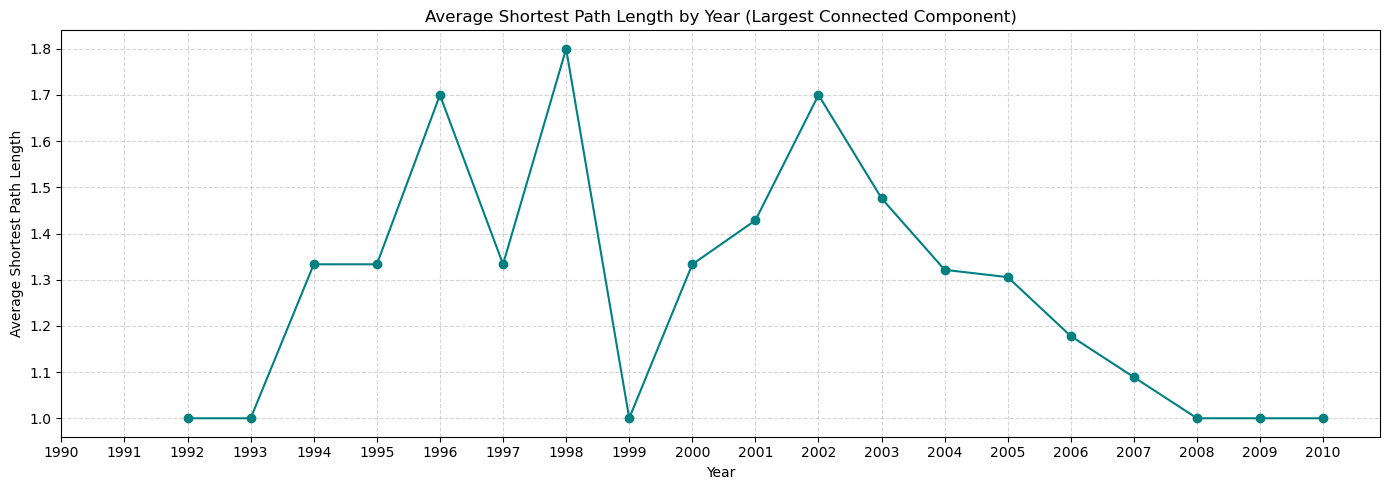

In [23]:
plt.figure(figsize=(14,5))
plt.plot(avg_shortest_paths_df.index, avg_shortest_paths_df['avg_shortest_path'], marker='o', linestyle='-', color='teal')
plt.xlabel('Year')
plt.ylabel('Average Shortest Path Length')
plt.title('Average Shortest Path Length by Year (Largest Connected Component)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(avg_shortest_paths_df.index, [str(int(y)) for y in avg_shortest_paths_df.index])
plt.tight_layout()
plt.savefig('../presentation/average_shortest_path_length.png', dpi=300, bbox_inches='tight')
plt.show()